# Training the Applicability Domain classification model

This notebook trains and saves the applicability domain (AD) model, which classifies molecules as inliers or outliers based on their molecular descriptors. 

In [1]:
import numpy as np
np.random.seed(0)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

In [2]:
# Load the training and testing datasets
from ysi_utils.descriptors import dragon
from ysi_utils.validation import y_train as y
from ysi_utils.validation import y_test

X = dragon.loc[y.index]
X_test = dragon.loc[y_test.index]

Here we create the descriptor pipeline and train it on the training set

In [3]:
# Descriptor outlier classification
from sklearn.ensemble import IsolationForest

outlier_pipeline = Pipeline([
    ('imputer', Imputer()),
    ('filter', VarianceThreshold()),
    ('scaler', StandardScaler()),
    ('feature_extraction', PCA(n_components=5)),
    ('outlier_clf', IsolationForest(contamination=0.075)),
    ])

outlier_pipeline.fit(X.values, y.values)
valid_classes = outlier_pipeline.predict(X)

y['inlier'] = (valid_classes == 1)

In choosing the hyperparameters of the outlier selection method, we are looking for a function that is able to distinguish between molecules similar to those in the training set and those that are not.

We therefore use the high-ysi dataset published in http://dx.doi.org/10.1016/j.combustflame.2006.11.003 and http://dx.doi.org/10.1016/j.proci.2008.06.197 as examples of molecules sufficiently different from the training set as a comparison

In [4]:
high_ysi = pd.read_pickle('high_ysi/high.p')
high_descriptors = pd.read_csv('high_ysi/high_descriptors.tsv',
                               sep='\t', index_col=0).set_index('NAME', drop=True)
high_descriptors = high_descriptors.loc[high_ysi.SMILES]
high_inliers = outlier_pipeline.predict(high_descriptors) == 1

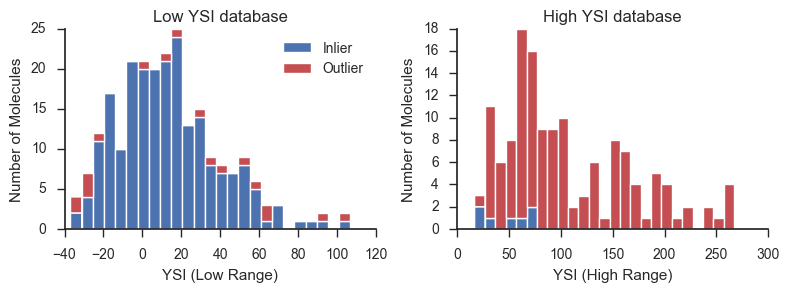

In [5]:
with sns.axes_style('ticks'):
    fig, axmatrix = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
    
    
    axmatrix[0].hist([y.YSI[y.inlier], y.YSI[~y.inlier]],
                     stacked=True, bins=25, rwidth=1., edgecolor='w',
                     linewidth=1., color=['b','r'], label=['Inlier', 'Outlier'])
    
    axmatrix[1].hist([high_ysi.YSI[high_inliers], high_ysi.YSI[~high_inliers]],
                     stacked=True, bins=25, rwidth=1., edgecolor='w',
                     linewidth=1., color=['b','r'])
    
    fig.tight_layout()
    sns.despine()
    
    axmatrix[0].set_title('Low YSI database')
    axmatrix[1].set_title('High YSI database')
    
    axmatrix[0].set_ylabel('Number of Molecules')
    axmatrix[1].set_ylabel('Number of Molecules')

    axmatrix[0].set_xlabel('YSI (Low Range)')
    axmatrix[1].set_xlabel('YSI (High Range)')
    
    axmatrix[0].legend(loc='upper right')

    fig.tight_layout()
    #fig.savefig('outlier_classification.svg', transparent=True)

The PCA step condenses the ~5000 descriptors (~3000 after variance threshold) into the 5 most important principle components. This reduced dimensionality captures ~67% of the total variance.

In [6]:
pca = outlier_pipeline.steps[3][1]
np.cumsum(pca.explained_variance_ratio_)[-1]

0.67257096377412784

We also use the test set compounds to verify that we are not over-fitting the applicability domain method. There should be a similar proportion of outliers in the test and training datasets

In [7]:
valid_classes_test = outlier_pipeline.predict(X_test)

print('{:.2%} of Training set marked as outliers'.format(
        1 - sum(valid_classes == 1) / len(valid_classes)))
print('{:.2%} of Test set marked as outliers'.format(
        1 - sum(valid_classes_test == 1) / len(valid_classes_test)))

7.56% of Training set marked as outliers
8.47% of Test set marked as outliers


In [8]:
y[~y.inlier]

,Species,Type,CAS,Ref,YSI,inlier
SMILES,,,,,,
CCCCCCCCCCC,n-undecane,Linear Alkanes,1120-21-4,3,53.3,False
CCCCCCCCCCCC,n-dodecane,Linear Alkanes,112-40-3,3,64.2,False
CC(CC(C)(C)C)CC(C)(C)C,"2,2,4,6,6-pentamethylheptane",Linear Alkanes,13475-82-6,3,106.9,False
C1CCCC1,cyclopentane,Cyclic Alkanes,287-92-3,3,14.0,False
C1CCCCC1,cyclohexane,Cyclic Alkanes,110-82-7,3,19.1,False
C1CCCCCCC1,cyclooctane,Cyclic Alkanes,292-64-8,3,42.4,False
CC1(C)CCCCC1,"1,1-dimethylcyclohexane",Cyclic Alkanes,590-66-9,3,58.2,False
C=CCCCCCCCCCC,1-dodecene,Alkenes,112-41-4,3,93.0,False
C1=CCCC1,cyclopentene,Cyclic Alkenes,142-29-0,3,61.8,False


In [11]:
y_test[valid_classes_test == -1]

,Species,Type,CAS,Ref,YSI
SMILES,,,,,
CC(C)=O,2-propanone (acetone),Saturated Alkanones,67-64-1,3,-26.9
CC(C)C(=O)O,isobutyric acid,Saturated Esters and Carboxylic Acids,79-31-2,3,-17.9
c1ccccc1,benzene,Aromatic,71-43-2,3,100.0
O=C1CCCCC1,cyclohexanone,Saturated Alkanones,108-94-1,3,6.1
COCCOCCO,2-(2-methoxyethoxy)-ethanol,Other Multi-Oxygen Compounds,111-77-3,3,-23.8


In [9]:
from sklearn.externals import joblib

joblib.dump(outlier_pipeline, '../ysi_utils/models/outliers.pkl', compress=9)

['../ysi_utils/models/outliers.pkl']